### Problema


Uma revista precisa catalogar todas as suas notícias em diferentes categorias. O objetivo desta competição é desenvolver o melhor modelo de aprendizagem profunda para prever a categoria de novas notícias.


<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Untitled-Diagram.png
" style="width: 400px;"/>


As categorias possíveis são:

* ambiente
* equilibrioesaude
* sobretudo
* educacao
* ciencia
* tec
* turismo
* empreendedorsocial
* comida

In [6]:
!pip install unidecode

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import requests
from unidecode import unidecode
import re
print(os.listdir("."))

['.config', 'train.csv', 'sample_data']


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(style="ticks")
warnings.filterwarnings("ignore")

In [0]:
# Bibliotecas do keras
import keras
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.regularizers import *
from keras.models import Sequential
from keras.callbacks import *
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

# Leitura do dataset de treinamento

In [10]:
# Leitura do Dataset
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(7894, 4)


,article_id,title,text,category
0,8409,Muralha de Lisboa é rota arqueológica com mais...,O urbanismo anárquico dos bairros mais antigos...,turismo
1,5714,Endeavor lança mapa inédito sobre negócios soc...,As empresas sociais mostraram que é possível u...,empreendedorsocial
2,9263,Falta de neve no Chile atrasa abertura de esta...,Ao menos quatro estações de esqui no centro do...,turismo
3,2649,Gravidez causa mudanças no cérebro das mulheres,"A gravidez provoca mudanças físicas ""duradoura...",ciencia
4,6698,Facebook provoca erros em aplicativo para test...,"Alguma vez você já ouviu a frase ""o Facebook e...",tec


Todos os artigos contêm o título e a descrição. Por último a categoria que pertence esse artigo.

In [0]:
# Definição de alguns parâmetros dos modelos e tokenização

# Tamanho da sequencia
seq_size     = 1000

# Máximo de tokens 
max_tokens   = 7000

# Tamanho do embedding
embed_dim    = 128

Iremos utilizar o titulo para o nosso modelo baseline. O processo abaixo cria o input da nossa rede e prepara o target.

In [12]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from urllib.parse import urlparse
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
import nltk 
nltk.download('rslp')
from nltk.stem import RSLPStemmer

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
tokenizer    = Tokenizer(num_words=max_tokens, split=' ')

def pre_processamento_texto(text):
  # Transforma o texto em números
  tokenizer.fit_on_texts(np.asarray(text))
  X = tokenizer.texts_to_sequences(np.asarray(text))  
  return pad_sequences(X, maxlen=seq_size)

In [0]:
stemmer = RSLPStemmer()
lemmatizer = WordNetLemmatizer()

In [0]:
# Funcao pra remorar URL
def is_url(url):
  try:
    result = urlparse(url)
    return all([result.scheme, result.netloc])
  except ValueError:
    return False

# Funcao para extrair o radical da palavra
def stemming(text):
  word_tokens = word_tokenize(text) 
  filtering = [stemmer.stem(w) for w in word_tokens]

  text_final = ' '.join(filtering)
  return text_final

# tratamento lexical das palavras
def lemmatizing(text):
  list_filter = []
  for word in text:
    word_tokens = word_tokenize(word) 
    filtering = [lemmatizer.lemmatize(w) for w in word_tokens]
    
  text_final = ' '.join(filtering)
  return text_final

# Funcao limpa texto
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
PONTUACTION = re.compile('[^\w\s]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('portuguese'))
STOPWORDS2 = ['r', 'h', 'u', 'ub']

def remove_palavras_recorrentes(text):
  text = ' '.join(word2 for word2 in text.split() if word2 not in STOPWORDS2)
  return text

def limpa_texto(text):
    text = text.lower() # lowercase text
    text = ' '.join(unidecode(word3) for word3 in text.split())
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    #text = ' '.join(word2 for word2 in text.split() if word2 not in STOPWORDS2)
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = PONTUACTION.sub('', text) # remove pontuaction
    text = ''.join([i for i in text if not i.isdigit()])# remove digits
    text = text.strip()
    return text

In [0]:
df = pd.read_csv("train.csv")

df = df.reset_index(drop=True)
df['content'] = df['text'] + '\n' + df['text']

df['content'] = [' '.join(y for y in x.split() if not is_url(y)) for x in df['content']]

# limpa texto
df['content'] = df['content'].apply(limpa_texto)

df['content'] = df['content'].apply(stemming)
df['content'] = df['content'].apply(remove_palavras_recorrentes)

text = df['content'].values

In [23]:
text[:2]

array(['urban anarqu bairr antig lisbo escond real colun vertebr trac antig muralh cuj recuperaca evidenci doi mil ano hist capit lus desd cidad banh tej cham olissip epoc roman ate reconqu crist sempr exist cerc velh muralh antig hoj vem send recuper percurs turis sinal continu send descobert pouc pouc const trabalh arqueolog e trabalh geraco geraco nao consegu acabal declar arqueolog manuel leita projet estud valorizaca cerc velh trabalh sobr muralh comec ano so sistem grac apoi ministeri tur portug hoj aind ha trech pend restauraca escavaco abr vari pont cidad muit cas sol priv iss leita afirm equip centr arqueolog prefeit lisboet permanec muit atent tod obr sao inici perimetr velh muralh result dess trabalh aind inacab pod ser vist desd ano pass atrav percurs sinal pont informaca que segund arqueolog suscit inter cresc turist lisboet tratas rot circul quilometr mei pont desd castel sao jorg ate marg tej segu trac muralh exist epoc domini islam lisbo cham alusbun do secul trabalh eq

In [24]:
# Cria sequencias de tamanho fixo (input: X)
X = pre_processamento_texto(text)
X

array([[   0,    0,    0, ...,  181, 1208, 2238],
       [   0,    0,    0, ...,   31,  600,   27],
       [   0,    0,    0, ...,  962, 3160, 1438],
       ...,
       [   0,    0,    0, ...,   13, 3603, 2254],
       [   0,    0,    0, ..., 2030,   29, 5476],
       [   0,    0,    0, ...,  156,    3, 3031]], dtype=int32)

In [0]:
# Categoriza o target "category" -> [0,..., 1] (output: y)
Y_classes = pd.get_dummies(df['category']).columns
Y         = pd.get_dummies(df['category']).values

In [26]:
Y_classes

Index(['ambiente', 'ciencia', 'comida', 'educacao', 'empreendedorsocial',
       'equilibrioesaude', 'sobretudo', 'tec', 'turismo'],
      dtype='object')

In [27]:
Y

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [28]:
(X.shape, Y.shape)

((7894, 1000), (7894, 9))

# Criação do Modelo

In [29]:
def create_model():
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(max_tokens, embed_dim, 
                        input_length = seq_size))
    # RNN Layer
    #model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    
    # Dense Layer
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(len(Y_classes), activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    model.summary()
    
    return model

model = create_model()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 128)         896000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 189       
Total params: 989,809
Trainable params: 989,809
Non-trainable params: 0
___________________________________________________________

In [30]:
# Separa o dataset em dados de treinamento/validação
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, 
                                                      test_size = 0.20, 
                                                      random_state = 42,
                                                      stratify=Y)

weights_filepath = "weights.h5"
callbacks = [ModelCheckpoint(weights_filepath, monitor='val_loss', mode='min',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)]

# Treina o modelo
hist = model.fit(X_train, Y_train, 
                 validation_data =(X_valid, Y_valid),
                 batch_size=150, nb_epoch = 100,  verbose = 1, callbacks=callbacks)
model.load_weights(weights_filepath)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6315 samples, validate on 1579 samples
Epoch 1/100





6315/6315 [==============================] - 101s 16ms/step - loss: 2.0359 - acc: 0.2198 - val_loss: 1.7673 - val_acc: 0.3281

Epoch 00001: val_loss improved from inf to 1.76728, saving model to weights.h5
Epoch 2/100
6315/6315 [==============================] - 93s 15ms/step - loss: 1.6076 - acc: 0.5256 - val_loss: 1.5263 - val_acc: 0.4927

Epoch 00002: val_loss improved from 1.76728 to 1.52627, saving model to weights.h5
Epoch 3/100
6315/6315 [==============================] - 93s 15ms/step - loss: 1.0310 - acc: 0.6614 - val_loss: 1.0360 - val_acc: 0.6567

Epoch 00003: val_loss improved from 1.52627 to 1.03601, saving model to weights.h5
Epoch 4/100
6315/6315 [==============================] - 95s 15ms/step - loss: 0.7351 - acc: 0.7606 - val_loss: 0.9439 - val_acc: 0.6992

Epoch 00004: val_loss improved from 1.03601 to 0.943

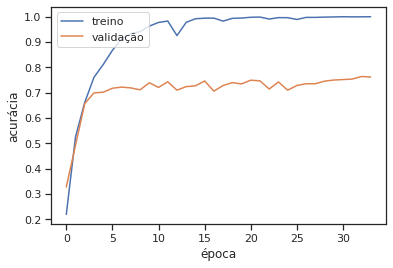

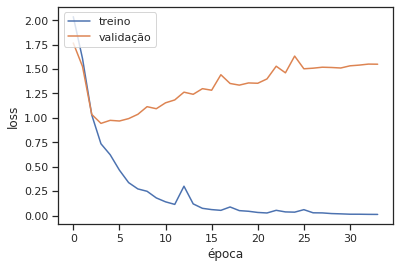

In [31]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'validação'], loc = 'upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('época')
plt.legend(['treino', 'validação'], loc = 'upper left')
plt.show()

##CNN

In [0]:
from keras.regularizers import *

In [33]:
def create_model():
    input_ = Input(shape=(seq_size,), dtype='int32')
    x = input_
    x = Embedding(max_tokens, embed_dim, input_length = seq_size)(x)
    
    x1 = Conv1D(100, 2, activation='relu')(x)
    x1 = MaxPooling1D(2)(x1)
    
    x2 = Conv1D(100, 3, activation='relu')(x)
    x2 = MaxPooling1D(3)(x2)
    
    x3 = Conv1D(100, 4, activation='relu')(x)
    x3 = MaxPooling1D(4)(x3)

    x4 = Conv1D(100, 5, activation='relu')(x)
    x4 = MaxPooling1D(5)(x4)

    x5 = Conv1D(100, 5, activation='relu')(x)
    x5 = MaxPooling1D(5)(x5)

    x = Concatenate(axis=1)([x1, x2, x3, x4, x5])
    x = Flatten()(x)
    
    x = Dense(8, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(len(Y_classes), activation='softmax')(x)
    
    model = Model(input_, x)
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    return model

model = create_model()
model.summary()

for layer in model.layers:
  layer.kernel_regularizer = l2(1e-5)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 128)    896000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 999, 100)     25700       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 998, 100)     38500       embedding_2[0][0]                
___________________________________________________________________________________________

In [34]:
# Separa o dataset em dados de treinamento/validação
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, 
                                                      test_size = 0.20, 
                                                      random_state = 42,
                                                      stratify=Y)

weights_filepath = "weights.h5"
callbacks = [ModelCheckpoint(weights_filepath, monitor='val_loss', mode='min',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', mode='min', patience=16, verbose=1)]

# Treina o modelo
hist = model.fit(X_train, Y_train, 
                 validation_data =(X_valid, Y_valid),
                 batch_size=300, nb_epoch = 100,  verbose = 1, callbacks=callbacks)
model.load_weights(weights_filepath)


Train on 6315 samples, validate on 1579 samples
Epoch 1/100
6315/6315 [==============================] - 9s 1ms/step - loss: 2.2708 - acc: 0.1781 - val_loss: 2.1921 - val_acc: 0.1742

Epoch 00001: val_loss improved from inf to 2.19207, saving model to weights.h5
Epoch 2/100
6315/6315 [==============================] - 3s 445us/step - loss: 2.1894 - acc: 0.1745 - val_loss: 2.1862 - val_acc: 0.1742

Epoch 00002: val_loss improved from 2.19207 to 2.18624, saving model to weights.h5
Epoch 3/100
6315/6315 [==============================] - 3s 445us/step - loss: 2.1836 - acc: 0.1745 - val_loss: 2.1804 - val_acc: 0.1742

Epoch 00003: val_loss improved from 2.18624 to 2.18039, saving model to weights.h5
Epoch 4/100
6315/6315 [==============================] - 3s 444us/step - loss: 2.1777 - acc: 0.1745 - val_loss: 2.1748 - val_acc: 0.1742

Epoch 00004: val_loss improved from 2.18039 to 2.17477, saving model to weights.h5
Epoch 5/100
6315/6315 [==============================] - 3s 444us/step - l

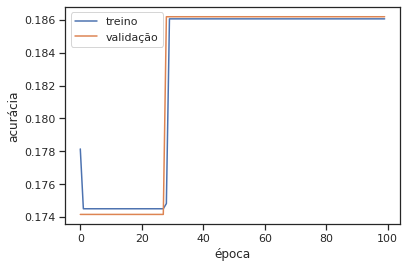

Text(0.5, 0, 'época')

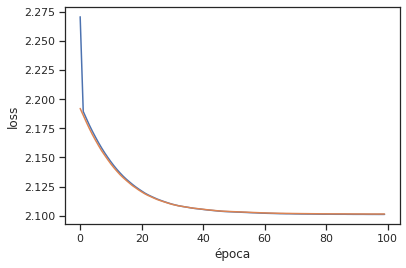

In [35]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'validação'], loc = 'upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('época')